In [1]:
import torch
import torchvision
from tqdm.notebook import tqdm, trange
from tqdm.utils import _term_move_up
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import List  # just to help readability

print(torch.__version__)
device_string = 'mps' if torch.backends.mps.is_built() else 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"MPS Available : {torch.backends.mps.is_built()}")
print (f"CUDA availabe : {torch.cuda.is_available()}")
DEVICE = torch.device(device_string)
print(f"GPU - {DEVICE}")
!jupyter nbextension enable --py widgetsnbextension

2.0.0
MPS Available : True
CUDA availabe : False
GPU - mps
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# looking at activations

Text(0, 0.5, 'ReLU(x)')

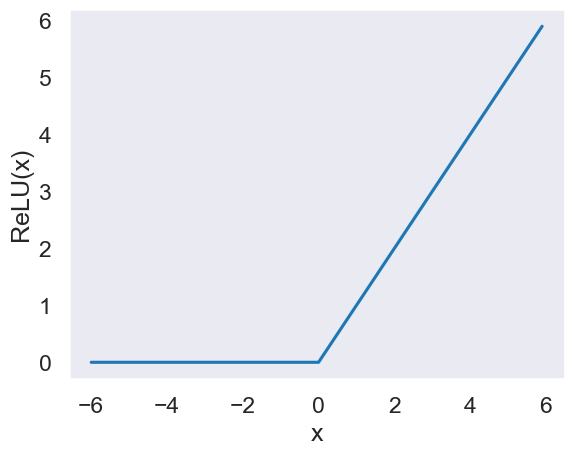

In [2]:
# Set the plot style
sns.set_context("talk")
sns.set_style("dark")
relu = torch.nn.ReLU()
input = torch.arange(-6, 6, step=0.1)
output = relu(input)
sns.lineplot(x=input, y=output)
plt.xlabel("x")
plt.ylabel("ReLU(x)")


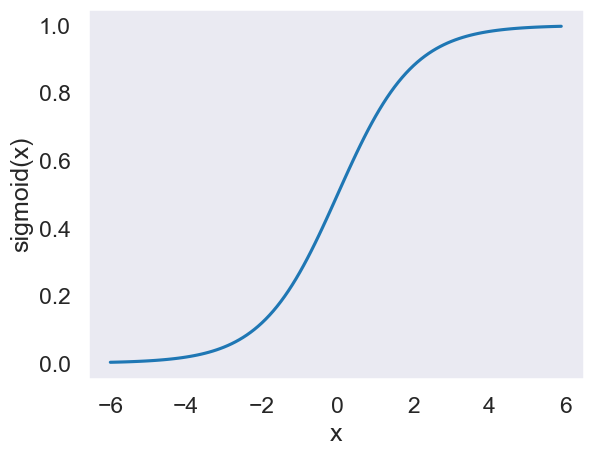

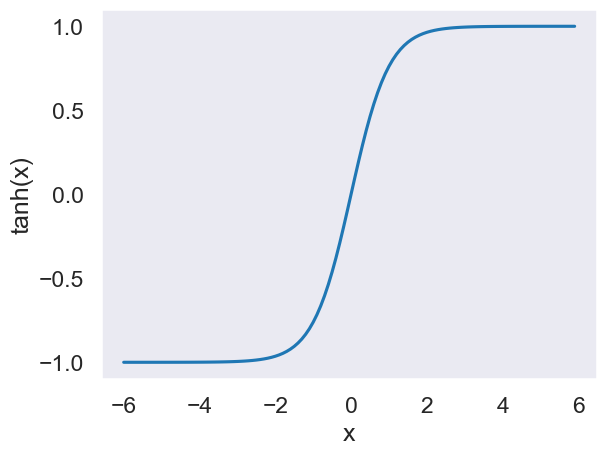

In [3]:
output_sigmoid = torch.nn.Sigmoid()(input)
sns.lineplot(x=input, y=output_sigmoid)
plt.xlabel("x")
plt.ylabel("sigmoid(x)")
plt.show()
output_tanh = torch.nn.Tanh()(input)
sns.lineplot(x=input, y=output_tanh)
plt.xlabel("x")
plt.ylabel("tanh(x)")
plt.show()


# MLP

In [4]:
# Generate Model
def create_sequential_model(dim_in: int, dim_out: int, hidden_layer_sizes: List[int]):
    print(dim_in)
    hiddens = [dim_in, *hidden_layer_sizes]
    torch_layers = []
    # Create a linear layer and feed it through a ReLU
    for i in range(len(hiddens) - 1):
        torch_layers.append(torch.nn.Linear(hiddens[i], hiddens[i + 1]))
        torch_layers.append(torch.nn.ReLU())
    torch_layers.append(
        torch.nn.Linear(hiddens[-1], dim_out)
    )  # create the output layer
    return torch.nn.Sequential(*torch_layers)


In [5]:
# Get datasets

CIFAR10_train = torchvision.datasets.CIFAR10(
    "CIFAR10_data", download=True, train=True, transform=True
)
CIFAR10_validation = torchvision.datasets.CIFAR10(
    "CIFAR10_data", download=True, train=False, transform=True
)
print(CIFAR10_train.data.shape)
print(len(CIFAR10_train.classes))
cifar_training_data = (CIFAR10_train.data.reshape((-1, 32 * 32 * 3)) / 255.0).astype(
    np.float32
)  # flatten the dataset and normalise
cifar_training_labels = np.asarray(CIFAR10_train.targets)
cifar_validation_data = (
    CIFAR10_validation.data.reshape((-1, 32 * 32 * 3)) / 255.0
).astype(
    np.float32
)  # flatten the dataset and normalise
cifar_validation_labels = np.asarray(CIFAR10_validation.targets)


MNIST_train = torchvision.datasets.MNIST(
    "MNIST_data", download=True, train=True, transform=True
)
MNIST_validation = torchvision.datasets.MNIST(
    "MNIST_data", download=True, train=False, transform=True
)
print(MNIST_train.data.shape)
print(len(MNIST_train.classes))
mnist_training_data = (
    MNIST_train.data.reshape((-1, 28 * 28)) / 255.0
)  # flatten the dataset and normalise
mnist_training_labels = np.asarray(MNIST_train.targets)
mnist_validation_data = (
    MNIST_validation.data.reshape((-1, 28 * 28)) / 255.0
)  # flatten the dataset and normalise
mnist_validation_labels = np.asarray(MNIST_validation.targets)


Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
10
torch.Size([60000, 28, 28])
10


In [6]:
# generate model

cifar_model = create_sequential_model(32 * 32 * 3, 10, [100, 100])
mnist_model = create_sequential_model(28 * 28, 10, [100, 100])


3072
784


In [7]:
# hyperparams

learning_rate = 5e-1  # starting learning rate that we can tweak to increase performance
batch_size = 256  # the number of datapoints per batch that we do
optimisation_steps = int(5e4)  # the number of batches that we train on


In [8]:
cifar_criterion = torch.nn.CrossEntropyLoss(reduction="mean")
cifar_optimiser = torch.optim.SGD(
    cifar_model.parameters(), lr=learning_rate
)  # model.parameters gives the weight matrices and biases to the optimiser (AKA trainable parameters)

cifar_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer=cifar_optimiser,
    milestones=[3000, 5000, 8000, 18000, 28000, 38000, 58000],
    gamma=0.5,
)


mnist_criterion = torch.nn.CrossEntropyLoss(reduction="mean")
mnist_optimiser = torch.optim.SGD(
    mnist_model.parameters(), lr=learning_rate
)  # model.parameters gives the weight matrices and biases to the optimiser (AKA trainable parameters)

mnist_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer=mnist_optimiser,
    milestones=[3000, 5000, 8000, 18000, 28000, 38000, 58000],
    gamma=0.5,
)


In [9]:
# train test loop
pbar = trange(optimisation_steps)

cifar_metrics = []
for i in pbar:
    idx = np.random.randint(
        0, cifar_training_data.shape[0], size=batch_size
    )  # random sample of batch_size indices from 0 to the number of datapoints the dataset has
    x = cifar_training_data[idx, :]  # get the datapoints at the sampled indices
    # flattened_x = torch.from_numpy(x.reshape(batch_size,-1)).as # flatten the datapoints
    y_pred = cifar_model(torch.from_numpy(x))  # predict the classes of the datapoints)
    cifar_loss = cifar_criterion(
        y_pred, torch.from_numpy(cifar_training_labels[idx])
    )  # compute the loss by comparing the predicted labels vs the actual labels
    # zero the gradients held by the optimiser
    cifar_optimiser.zero_grad()
    # perform a backward pass to compute the gradients
    cifar_loss.backward()
    # update the weights
    cifar_optimiser.step()
    if i % 100 == 99:
        if i % 1000 == 999:
            train_pred = cifar_model(torch.from_numpy(cifar_training_data))
            val_pred = cifar_model(torch.from_numpy(cifar_validation_data))
            cifar_train_accuracy = torch.mean(
                (
                    train_pred.argmax(dim=1) == torch.from_numpy(cifar_training_labels)
                ).float()
            )
            cifar_val_accuracy = torch.mean(
                (
                    val_pred.argmax(dim=1) == torch.from_numpy(cifar_validation_labels)
                ).float()
            )
            # print the loss every 100 steps
            cifar_metrics.append(
                [
                    i,
                    cifar_loss.item(),
                    cifar_train_accuracy.numpy(),
                    cifar_val_accuracy.numpy(),
                ]
            )
        print(f"\rEpoch: {i} Loss:{round(cifar_loss.item(),2)}", end="")
    cifar_scheduler.step()


  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch: 49999 Loss:1.16

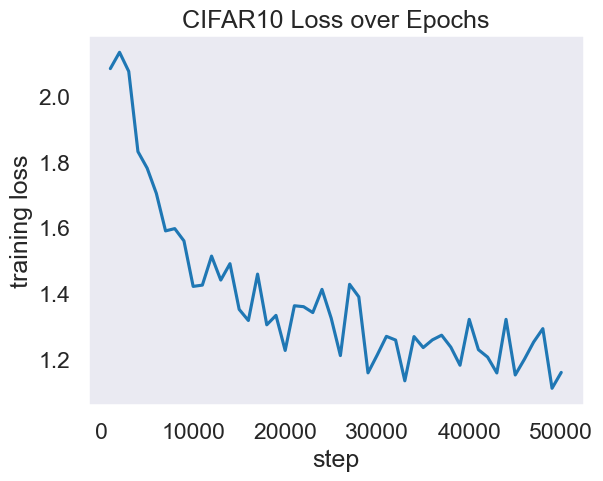

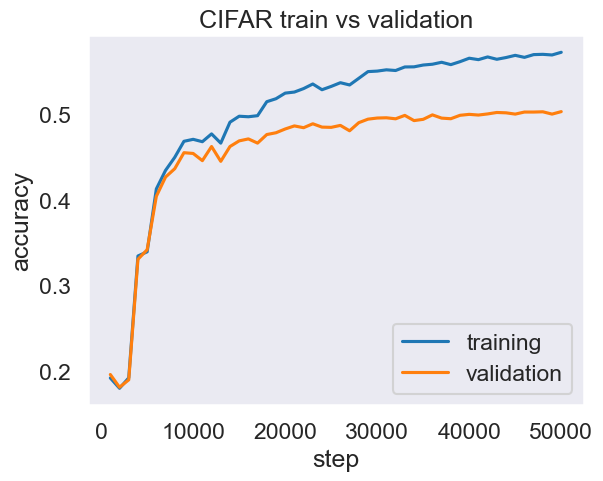

In [10]:
cifar_metrics = np.asarray(cifar_metrics)
sns.lineplot(x=cifar_metrics[:, 0], y=cifar_metrics[:, 1])
plt.title("CIFAR10 Loss over Epochs")
plt.xlabel("step")
plt.ylabel("training loss")
plt.show()
sns.lineplot(x=cifar_metrics[:, 0], y=cifar_metrics[:, 2], label="training")
sns.lineplot(x=cifar_metrics[:, 0], y=cifar_metrics[:, 3], label="validation")
plt.title("CIFAR train vs validation")
plt.xlabel("step")
plt.ylabel("accuracy")
plt.show()


In [11]:
# train test loop
pbar = trange(optimisation_steps)

mnist_metrics = []
for i in pbar:
    idx = np.random.randint(
        0, mnist_training_data.shape[0], size=batch_size
    )  # random sample of batch_size indices from 0 to the number of datapoints the dataset has
    x = mnist_training_data[idx, :]  # get the datapoints at the sampled indices
    # flattened_x = torch.from_numpy(x.reshape(batch_size,-1)) # flatten the datapoints
    y_pred = mnist_model(x)  # predict the classes of the datapoints)
    mnist_loss = mnist_criterion(
        y_pred, torch.from_numpy(mnist_training_labels[idx])
    )  # compute the loss by comparing the predicted labels vs the actual labels
    # zero the gradients held by the optimiser
    mnist_optimiser.zero_grad()
    # perform a backward pass to compute the gradients
    mnist_loss.backward()
    # update the weights
    mnist_optimiser.step()
    if i % 100 == 99:
        if i % 1000 == 999:
            train_pred = mnist_model(mnist_training_data)
            val_pred = mnist_model(mnist_validation_data)
            mnist_train_accuracy = torch.mean(
                (
                    train_pred.argmax(dim=1) == torch.from_numpy(mnist_training_labels)
                ).float()
            )
            mnist_val_accuracy = torch.mean(
                (
                    val_pred.argmax(dim=1) == torch.from_numpy(mnist_validation_labels)
                ).float()
            )
            # print the loss every 100 steps
            mnist_metrics.append(
                [
                    i,
                    mnist_loss.item(),
                    mnist_train_accuracy.numpy(),
                    mnist_val_accuracy.numpy(),
                ]
            )
        print(f"\rEpoch: {i} Loss:{round(mnist_loss.item(),2)}", end="")
    mnist_scheduler.step()


  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch: 49999 Loss:0.01

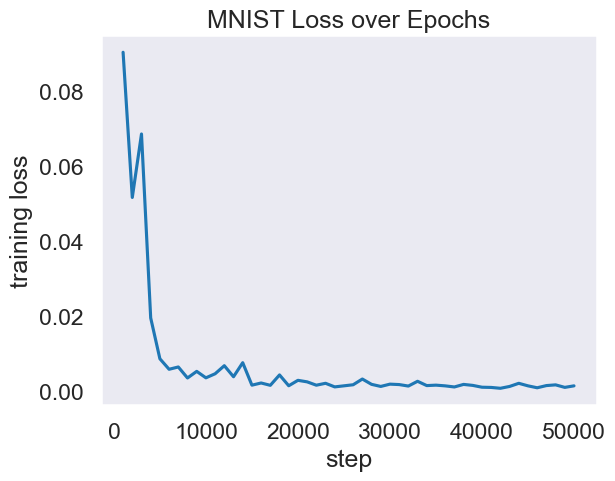

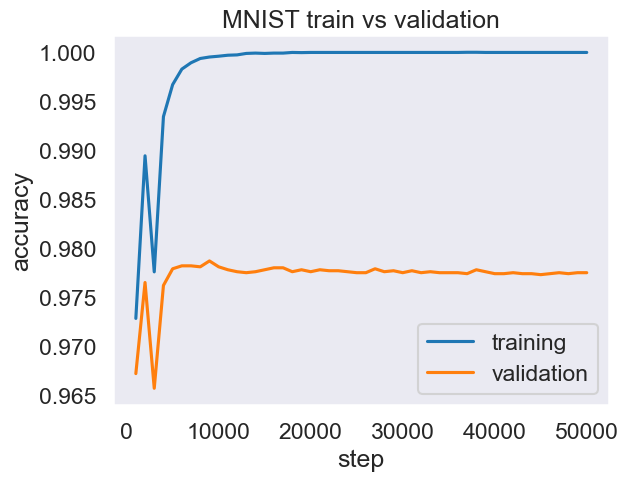

In [12]:
mnist_metrics = np.asarray(mnist_metrics)
sns.lineplot(x=mnist_metrics[:, 0], y=mnist_metrics[:, 1])
plt.title("MNIST Loss over Epochs")
plt.xlabel("step")
plt.ylabel("training loss")
plt.show()
sns.lineplot(x=mnist_metrics[:, 0], y=mnist_metrics[:, 2], label="training")
sns.lineplot(x=mnist_metrics[:, 0], y=mnist_metrics[:, 3], label="validation")
plt.title("MNIST train vs validation")
plt.xlabel("step")
plt.ylabel("accuracy")
plt.show()


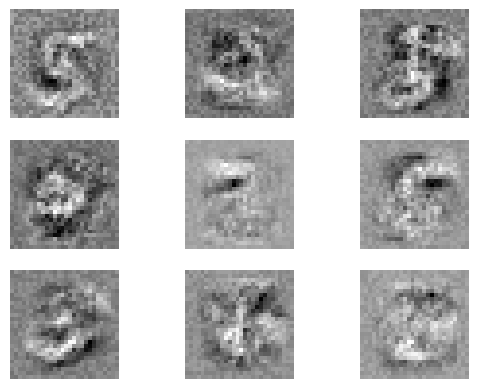

In [13]:
# assuming the weight matrix is named "W" and has shape (num_neurons, num_inputs)
weights = mnist_model[0].weight.data

# plot the first 9 rows of the weight matrix as images
fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(weights[i * 3 + j].reshape(28, 28), cmap="gray")
        axs[i, j].axis("off")
plt.show()
